# Carbon Dioxide Emissions Prediction Model

In [176]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import linspace

## Linear Regression Implementation using Batch Gradient Descent
This class defines a linear regression model that acceps the learning rate and the epochs (number of iterations for the batch gradient descent) as hyperparameters. There are essentailly two functions:
- `fit(X, Y)`: takes the features and the corresponding value to train the model
- `predict(X)`: takes a list of features and returns the model's predicted values


In [177]:
# Implementation of Linear Regression using Batch Gradient Descent
class LinearRegression:
    def __init__(self, lr=0.001, epochs=1000):
        self.learning_rate = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None


    def fit(self, X, Y):
        sample_count, feature_count = len(X), len(X[0])
        self.weights = [60.0] * feature_count
        self.bias = 0.0

        for _ in range(self.epochs):
            y_preds = [self.bias] * sample_count
            for i in range(sample_count):
                for fi in range(feature_count):
                    y_preds[i] += X[i][fi] * self.weights[fi]
            
            y_diff = [y_preds[i] - Y[i] for i in range(len(Y))]
            bias_diff = (2/sample_count) * sum(y_diff)

            weight_diff = [0] * feature_count
            for i in range(sample_count):
                for fi in range(feature_count):
                    weight_diff[fi] += (X[i][fi] * y_diff[i])
            
            for fi in range(feature_count):
                weight_diff[fi] *= 1/sample_count
            
            self.bias -= self.learning_rate * bias_diff
            for fi in range(len(self.weights)):
                self.weights[fi] -= self.learning_rate * weight_diff[fi]
            

    def predict(self, X):
        res = [self.bias] * len(X)
        for i in range(len(X)):
            for fi in range(len(X[0])):
                res[i] += self.weights[fi] * X[i][fi]
        
        return res

# Performance Metrics

In [178]:
def mean_absolute_error(real_values, predicted_values):
    ms = 0
    for i in range(len(real_values)):
        ms += abs(real_values[i] - predicted_values[i])
    
    ms /= len(real_values)
    return ms

def root_mean_squared_error(real_values, predicted_values):
    ms = 0
    for i in range(len(real_values)):
        ms += pow(real_values[i] - predicted_values[i], 2)
    
    ms /= len(real_values)
    return pow(ms, 0.5)


def coefficient_of_determination(real_values, predicted_values):
    mean_real = sum(real_values) / len(real_values)
    
    total_variance = sum((val - mean_real) ** 2 for val in real_values)
    explained_variance = sum((real_values[i] - predicted_values[i]) ** 2 for i in range(len(real_values)))
    
    r_squared = 1 - (explained_variance / total_variance)
    return r_squared


#### Importing the data and dividing it into a training, testing and validation sets using a 60-20-20 split 

In [179]:
# Import the dataset and filter out unnecessary features
data = pd.read_csv("./data/CO2_Emissions.csv")

In [180]:
data.shape

(7385, 12)

In [181]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [182]:
columns = [
    'Make',  
    'Vehicle Class', 
    'Engine Size(L)', 
    'Fuel Consumption City (L/100 km)', 
    'Fuel Consumption Hwy (L/100 km)', 
    'Fuel Consumption Comb (L/100 km)', 
    'Transmission', 
    'CO2 Emissions(g/km)'
]

data = data[columns]
# Renaming the columns that Have space in their names
data.columns = [col.replace(' ', '_') for col in data.columns]


data.head()

,Make,Vehicle_Class,Engine_Size(L),Fuel_Consumption_City_(L/100_km),Fuel_Consumption_Hwy_(L/100_km),Fuel_Consumption_Comb_(L/100_km),Transmission,CO2_Emissions(g/km)
0,ACURA,COMPACT,2.0,9.9,6.7,8.5,AS5,196
1,ACURA,COMPACT,2.4,11.2,7.7,9.6,M6,221
2,ACURA,COMPACT,1.5,6.0,5.8,5.9,AV7,136
3,ACURA,SUV - SMALL,3.5,12.7,9.1,11.1,AS6,255
4,ACURA,SUV - SMALL,3.5,12.1,8.7,10.6,AS6,244


In [183]:
# Lets see how many unique categories we have for the categorical columns
categorical_columns = ['Make', 'Vehicle_Class', 'Transmission']
unique_counts = data[categorical_columns].nunique()

print(unique_counts)

Make             42
Vehicle_Class    16
Transmission     27
dtype: int64


- Using one hot encoding for the categorical columns

In [184]:

encoded_data = pd.get_dummies(data, columns=['Make', 'Vehicle_Class', 'Transmission'], drop_first=True)
encoded_data = encoded_data.astype(int)
data = pd.DataFrame(encoded_data)
data.head()


,Engine_Size(L),Fuel_Consumption_City_(L/100_km),Fuel_Consumption_Hwy_(L/100_km),Fuel_Consumption_Comb_(L/100_km),CO2_Emissions(g/km),Make_ALFA ROMEO,Make_ASTON MARTIN,Make_AUDI,Make_BENTLEY,Make_BMW,...,Transmission_AS8,Transmission_AS9,Transmission_AV,Transmission_AV10,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7
0,2,9,6,8,196,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,11,7,9,221,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,6,5,5,136,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,3,12,9,11,255,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,12,8,10,244,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
# separate the last column and split the data
data_x = data.drop(columns=['CO2_Emissions(g/km)'])
data_y = data['CO2_Emissions(g/km)']


train_x, temp_x, train_y, temp_y = train_test_split(data_x, data_y, test_size=0.40, random_state=42)
validation_x, test_x, validation_y, test_y = train_test_split(temp_x, temp_y, test_size=0.50, random_state=42)

## Showing that the conditions for Linear Regression are met
The following are the conditions that determine whether linear regression is an appropriate model for a given problem:

- ***Linear relationship***: states that there should be a linear relationship between the dependent and independent variables. This shall be demonstrated for each of the features in our dataset.

- ***Homoscedasticity***: states that the variance of residuals should be consistent across all levels of the independent variables. This can also be demonstrated with the aforementioned graphs.

- ***No Multicollinearity***: states that independent variables must not be too highly correlated with each other.

- ***Normality of Errors***: states that the residuals (differences between observed and predicted values) should be normally distributed. This can be verified using a histogram or Q-Q plot of residuals.

- ***No Autocorrelation of Errors***: states that the residuals should not show patterns over time or across observations, ensuring they are independent of one another. This can be tested using the Durbin-Watson test.


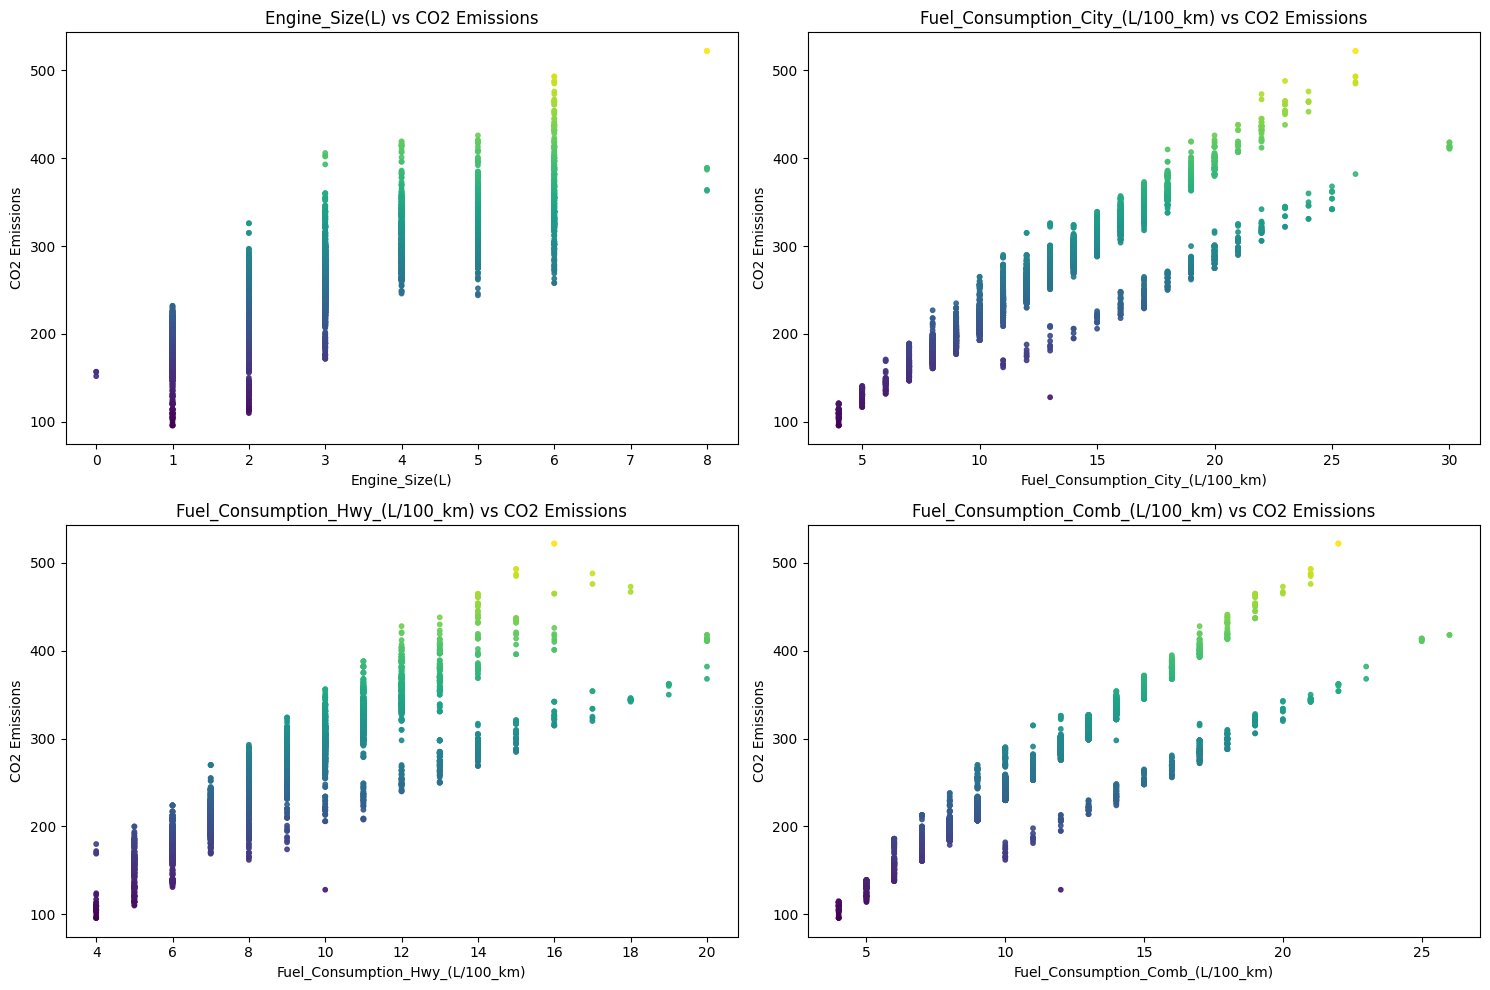

In [ ]:

selected_features = ['Engine_Size(L)', 'Fuel_Consumption_City_(L/100_km)', 
                     'Fuel_Consumption_Hwy_(L/100_km)', 'Fuel_Consumption_Comb_(L/100_km)']

plt.figure(figsize=(15, 10))  

for i, feature in enumerate(selected_features):
    plt.subplot(2, 2, i + 1)  
    plt.scatter(data_x[feature], data_y, s=10, c=data_y, cmap="viridis", alpha=0.9)
    plt.title(f'{feature} vs CO2 Emissions')
    plt.xlabel(feature)
    plt.ylabel("CO2 Emissions")

plt.tight_layout() 
plt.show()


## Training the model and tuning the hyperparameters

The learning rate will be tweaked to find a good middleground among all the hyperparameters. The validation data subset will be used to establish the best pair of hyperparameters for this particular model.

In [ ]:
# Make several models using different learning rates and epochs and use the performance metric measures to check how well they perform
# learning_rates = [0.00001, 0.0003, 0.0002, 0.0005, 0.0001]
learning_rates = [0.0001]
models = [LinearRegression() for lr in learning_rates]

conv_train_x = train_x.values.tolist()
conv_train_y = list(train_y)

# Visualize features of the training data subset
train_x

,Make,Vehicle Class,Engine Size(L),Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Transmission
5170,MERCEDES-BENZ,SPECIAL PURPOSE VEHICLE,2.0,11.5,9.8,10.7,A7
1779,LEXUS,SUBCOMPACT,3.5,12.3,8.5,10.6,AS8
4503,BMW,SUV - STANDARD,3.0,13.0,9.8,11.5,AS8
4588,CHEVROLET,MID-SIZE,1.8,4.8,5.5,5.1,AV
1818,MAZDA,MID-SIZE,2.5,8.7,6.5,7.7,AS6
...,...,...,...,...,...,...,...
5191,MINI,SUBCOMPACT,2.0,10.3,7.4,9.0,M6
5226,NISSAN,MID-SIZE,3.5,10.6,7.3,9.1,AV7
5390,TOYOTA,SUV - STANDARD,3.5,11.7,8.8,10.4,AS8
860,NISSAN,SUV - SMALL,2.5,9.5,7.4,8.6,AV


In [ ]:
# Visualize results of the training data subset
train_y

5170    251
1779    244
4503    270
4588    121
1818    177
       ... 
5191    210
5226    214
5390    242
860     198
7270    279
Name: CO2 Emissions(g/km), Length: 4431, dtype: int64

#### Train each model, run the test with the validation data subset and choose the best performing model

In [ ]:
# Train each model
for model in models:
    model.fit(conv_train_x, conv_train_y)

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
conv_validation_x = validation_x.values.tolist()
conv_validation_y = list(validation_y)

rms_scores = [0] * len(models)
for i, model in enumerate(models):
    print(f" | Running validation tests for model #{i+1}")
    rms_scores[i] = root_mean_squared_error(conv_validation_y, model.predict(conv_validation_x))
    print(f" | Model #{i+1} scored an RMS value of: {round(rms_scores[i], 2)}")

best_model_index = 0
for i in range(len(models)):
    if rms_scores[i] > rms_scores[best_model_index]:
        best_model_index = i

best_model = models[best_model_index]
print(f"\n | Model {best_model_index + 1} with a learning rate of {learning_rates[best_model_index]} has the best score.")

 | Running validation tests for model #1
 | Model #1 scored an RMS value of: 26.03

 | Model 1 with a learning rate of 0.0001 has the best score.


# Testing the Model

The testing data subset will be used along with the following performance metrics to evaluate the final version of the model:


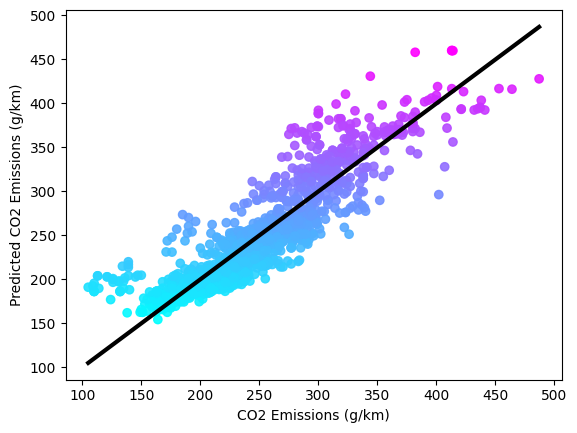

In [ ]:
predictions = best_model.predict(test_x.values.tolist())
value_range = [test_y.min(), test_y.max()]

# compare the predicted values and the actual values
plt.scatter(list(test_y), predictions, c=predictions, cmap="cool", alpha=0.9)
plt.plot(value_range, value_range, lw="3", color="black")
plt.xlabel("CO2 Emissions (g/km)")
plt.ylabel("Predicted CO2 Emissions (g/km)")
plt.show()

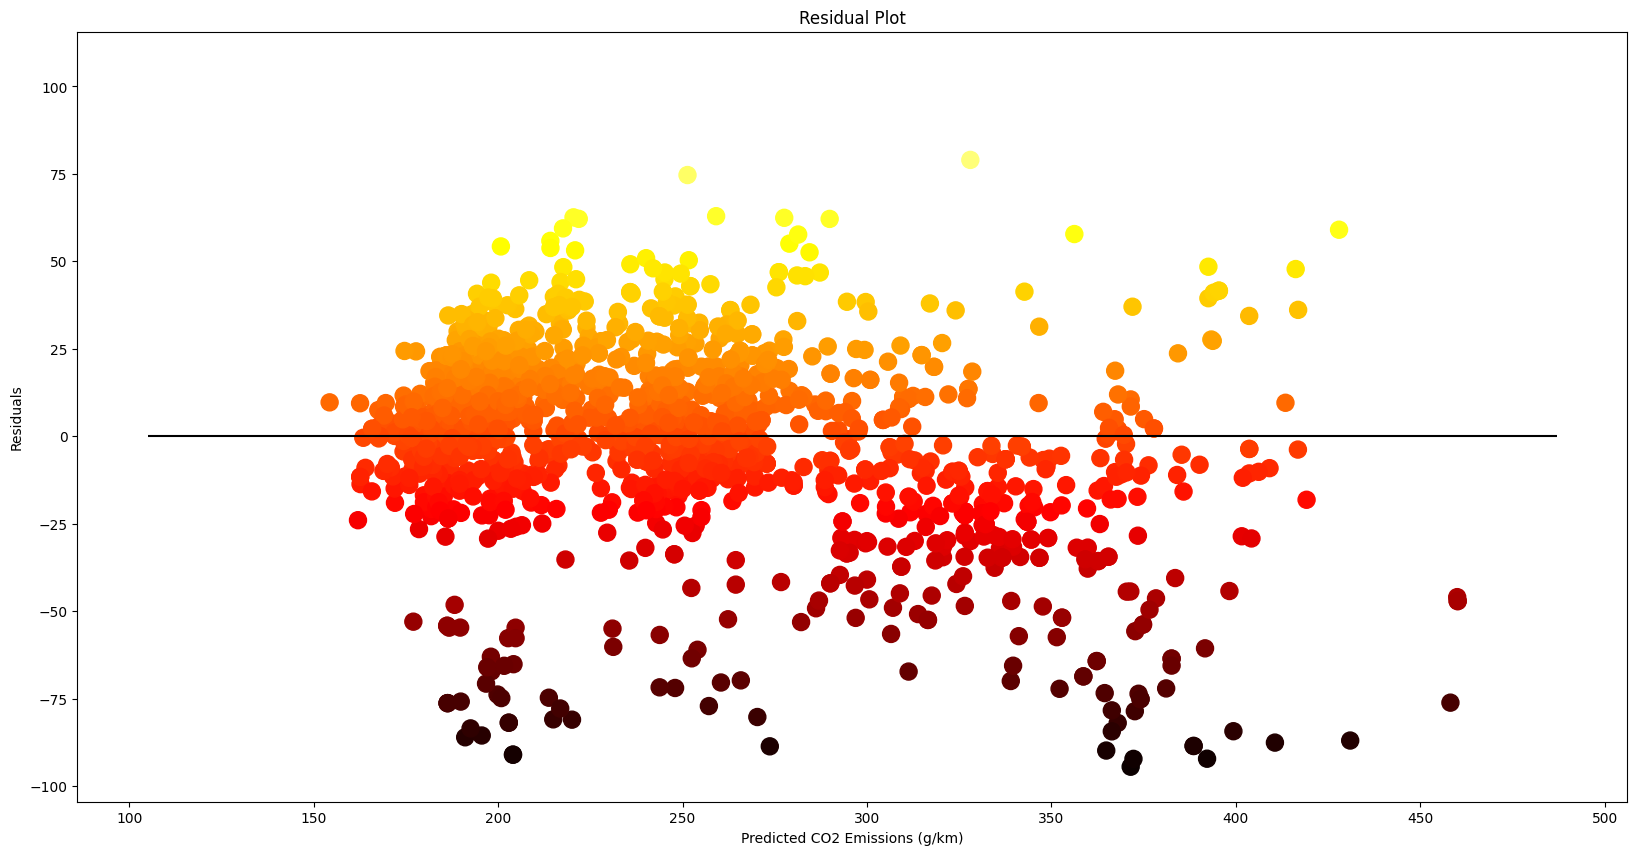

In [ ]:
residuals = [list(test_y)[i] - predictions[i] for i in range(len(test_y))]

# plot the residuals
plt.figure(figsize=(20, 10))
plt.scatter(predictions, residuals, c=residuals, cmap="hot", s=150)
plt.hlines(y=0, xmin=value_range[0], xmax=value_range[1], color="black")
plt.xlabel("Predicted CO2 Emissions (g/km)")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

- Evaluating the model using performance metrics

In [ ]:

conv_test_x = test_x.values.tolist()
conv_test_y = list(test_y)


test_predictions = best_model.predict(conv_test_x)


mae = mean_absolute_error(conv_test_y, test_predictions)
rmse = root_mean_squared_error(conv_test_y, test_predictions)
r_squared = coefficient_of_determination(conv_test_y, test_predictions)


print(f"Performance metrics for the best model (learning rate = {learning_rates[best_model_index]}):")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Coefficient of Determination (R^2): {r_squared}")


Performance metrics for the best model (learning rate = 0.0001):
Mean Absolute Error (MAE): 19.444159096576954
Root Mean Squared Error (RMSE): 26.542140400178663
Coefficient of Determination (R^2): 0.7881306308682462
